In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from key_door import key_door_env, visualisation_env
from sac.models import dqn, ppo

from sklearn.metrics.pairwise import cosine_similarity

In [40]:
map_path = '../sac/maps/meister_maze.txt'
map_yaml_path = '../sac/maps/test_meister_maze_shaped_2.yaml'
# map_yaml_path = '../sac/maps/meister_maze.yaml'

In [41]:
env = key_door_env.KeyDoorEnv(map_ascii_path=map_path, map_yaml_path=map_yaml_path, representation="pixel", episode_timeout=200)
env = visualisation_env.VisualisationEnv(env)

In [42]:
sample_state = env.reset_environment(train=False)
state_space = env.state_space
action_space = env.action_space
num_actions = len(action_space)

state_shape = sample_state.shape[1:]

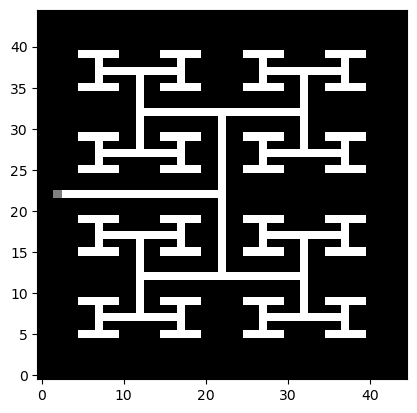

In [43]:
env.render()

## DQN

In [31]:
results_path = "../sac/results/2025-06-10-21-13"
args_text = open(f"{results_path}/args.txt", "r").read()
print(args_text)

model: dqn
learning_rate: 0.0003
discount_factor: 0.99
exploration_rate: 1.0
optimistic_init: 10.0
exploration_decay: 0.995
num_episodes: 10000
num_steps: 100000
batch_size: 64
target_update_frequency: 50
replay_buffer_size: 50000
burnin: 5000
gae_lambda: 0.95
update_epochs: 10
value_function_coef: 0.5
entropy_coef: 0.01
clip_coef: 0.2
max_grad_norm: 0.5
convolutional: True
test_frequency: 50
save_model_frequency: 50
visualisation_frequency: 50
map_name: meister_maze.txt
map_yaml_filename: meister_maze.yaml
test_map_yaml_filename: test_meister_maze.yaml
representation: pixel
episode_timeout: 200
results_dir: results



In [32]:
dqn_model = dqn.DQN(
    sample_state=sample_state,
    num_actions=num_actions,
    learning_rate=0.0,
    discount_factor=0.99,
    exploration_rate=0.01,
    exploration_decay=1.0,
    batch_size=64,
    target_update_frequency=1000,
    replay_buffer_size=10000,
    burnin=1000,
    convolutional=True,
    optimistic_init=False
)

In [33]:
state_id_mapping = {state: i for i, state in enumerate(env.positional_state_space)}
id_state_mapping = {i: state for i, state in enumerate(env.positional_state_space)}

In [34]:
# get representations
def get_representations(model, states):
    model._net.eval()
    network = model._net
    states = torch.tensor(states, dtype=torch.float32).to('cuda')
    with torch.no_grad():
        x = torch.relu(network.conv1(states))
        x = torch.relu(network.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(network.fc1(x))
        # x = network.fc1(x)
    return x

In [35]:
S = len(env.positional_state_space)
A = len(env.action_space)

reprs = []

for state in env.positional_state_space:
    state_input = env.get_state_representation(state)
    reprs.append(get_representations(dqn_model, state_input).cpu().numpy())

reprs = np.vstack(reprs)  # Shape: (S, representation_dim)
reprs.shape

(393, 128)

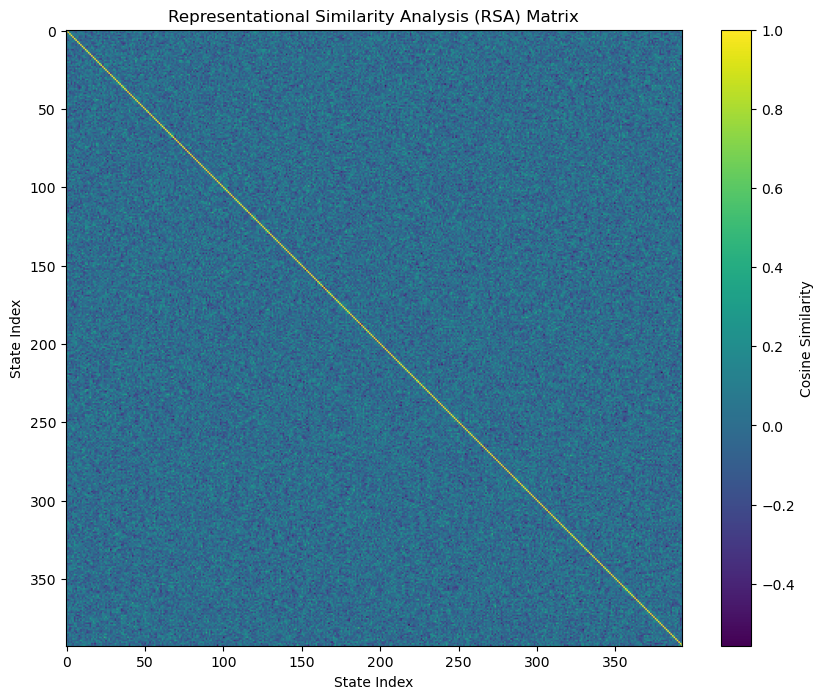

In [36]:
reprs -= reprs.mean(axis=0)

rsa_matrix = cosine_similarity(reprs)  # Shape: (S, S)
plt.figure(figsize=(10, 8))
plt.imshow(rsa_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Representational Similarity Analysis (RSA) Matrix')
plt.xlabel('State Index')
plt.ylabel('State Index')
plt.show()

In [37]:
model_dict = torch.load(f"{results_path}/dqn_model_9950.pth")
dqn_model._net.load_state_dict(model_dict["model_state_dict"])
dqn_model._net.eval()

/tmp/ipykernel_1090003/2146058129.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(f"{results_path}/dqn_model_9950.pth")


ConvDQNNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=64800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [39]:
S = len(env.positional_state_space)
A = len(env.action_space)

reprs = []

for state in env.positional_state_space:
    state_input = env.get_state_representation(state)
    reprs.append(get_representations(dqn_model, state_input).cpu().numpy())

reprs = np.vstack(reprs)  # Shape: (S, representation_dim)
reprs.shape

(393, 128)

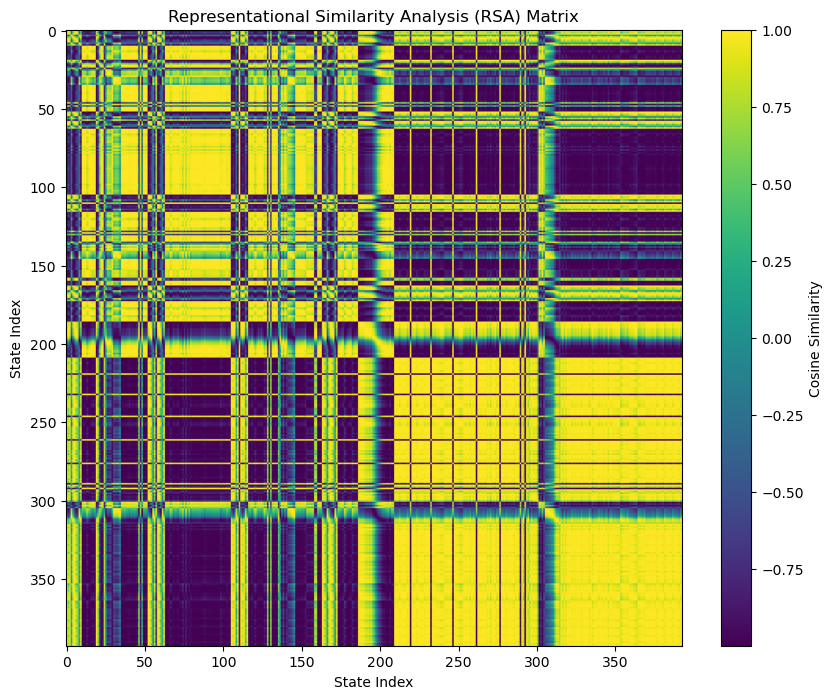

In [40]:
reprs -= reprs.mean(axis=0)

rsa_matrix = cosine_similarity(reprs)  # Shape: (S, S)
plt.figure(figsize=(10, 8))
plt.imshow(rsa_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.title('Representational Similarity Analysis (RSA) Matrix')
plt.xlabel('State Index')
plt.ylabel('State Index')
plt.show()

## PPO

In [60]:
results_path = "../sac/invisible_reward_runs/2025-10-10-17-02"
args_text = open(f"{results_path}/args.txt", "r").read()
print(args_text)

model: ppo
learning_rate: 0.001
weight_decay: 0.001
layer_norm: False
discount_factor: 0.99
exploration_rate: 1.0
optimistic_init: 0.0
exploration_decay: 0.995
num_episodes: 1000
num_steps: 1000000
batch_size: 64
target_update_frequency: 50
replay_buffer_size: 10000
burnin: 1000
gae_lambda: 0.95
update_epochs: 10
value_function_coef: 0.5
entropy_coef: 0.05
clip_coef: 0.2
max_grad_norm: 0.5
convolutional: True
test_frequency: 10
save_model_frequency: 10
visualisation_frequency: 10
map_name: meister_maze.txt
map_yaml_filename: test_meister_maze_shaped_2.yaml
test_map_yaml_filename: test_meister_maze_shaped_2.yaml
representation: pixel
episode_timeout: 200
results_dir: invisible_reward_runs



In [61]:
from copy import deepcopy

ppo_model = ppo.PPO(
            sample_state=sample_state,
            num_actions=num_actions,
            batch_size=64,
            replay_buffer_size=10000,
            learning_rate=3e-4,
            discount_factor=0.99,
            gae_lambda=0.95,
            clip_coef=0.2,
            vf_coef=0.5,
            ent_coef=0.01,
            max_grad_norm=0.5,
            convolutional=True,
        )

random_init_model = deepcopy(ppo_model)

In [62]:
# get representations
def get_representations(model, state):
    model._net.eval()
    network = model._net
    with torch.no_grad():
        x = torch.relu(network.conv1(state))
        x = torch.relu(network.conv2(x))
        x_c = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(network.fc1(x_c))
        x = torch.relu(network.fc2(x))
        actor_repr = network.pi_fc(x)
        critic_repr = network.v_fc(x)
    return x_c, x, actor_repr, critic_repr

In [63]:
def plot_rsa_matrix(reprs, title):
    reprs_ = reprs - reprs.mean(axis=0)
    rsa_matrix = cosine_similarity(reprs_)  # Shape: (S, S)
    plt.figure(figsize=(10, 8))
    plt.imshow(rsa_matrix, cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title(title)
    plt.xlabel('State Index')
    plt.ylabel('State Index')
    plt.show()

In [64]:
def accumulate_and_plot(model, env):
    conv_reprs = []
    shared_reprs = []
    actor_reprs = []
    critic_reprs = []
    state_reprs = []

    i = 0

    for state in env.positional_state_space:
        env.move_agent_to(state)  # Move agent to position
        state_input = env.get_state_representation()
        shape = (1, ) + state_shape
        state_input = torch.FloatTensor(state_input.reshape(shape)).to('cuda')
        conv, shared, actor, critic = get_representations(model, state_input)
        conv_reprs.append(conv.cpu().numpy())
        shared_reprs.append(shared.cpu().numpy())
        actor_reprs.append(actor.cpu().numpy())
        critic_reprs.append(critic.cpu().numpy())
        state_reprs.append(state_input.cpu().numpy())

    conv_reprs = np.vstack(conv_reprs)  # Shape: (S, convolutional_representation_dim)
    shared_reprs = np.vstack(shared_reprs)  # Shape: (S, representation_dim)
    actor_reprs = np.vstack(actor_reprs)  # Shape: (S, actor_representation_dim)
    critic_reprs = np.vstack(critic_reprs)  # Shape: (S, critic_representation_dim)
    state_reprs = np.vstack(state_reprs).reshape(len(state_reprs), -1)  # Shape: (S, state_representation_dim)

    print("Input State Representation Shape:", state_reprs.shape)
    print("Convolutional Representation Shape:", conv_reprs.shape)
    print("Shared Representation Shape:", shared_reprs.shape)
    print("Actor Representation Shape:", actor_reprs.shape)
    print("Critic Representation Shape:", critic_reprs.shape)

    plot_rsa_matrix(state_reprs, "Input State Representation RSA Matrix")
    plot_rsa_matrix(conv_reprs, "Convolutional Representation RSA Matrix")
    plot_rsa_matrix(shared_reprs, "Shared Representation RSA Matrix")
    plot_rsa_matrix(actor_reprs, "Actor Representation RSA Matrix")
    plot_rsa_matrix(critic_reprs, "Critic Representation RSA Matrix")

Input State Representation Shape: (393, 2025)
Convolutional Representation Shape: (393, 64800)
Shared Representation Shape: (393, 128)
Actor Representation Shape: (393, 128)
Critic Representation Shape: (393, 128)


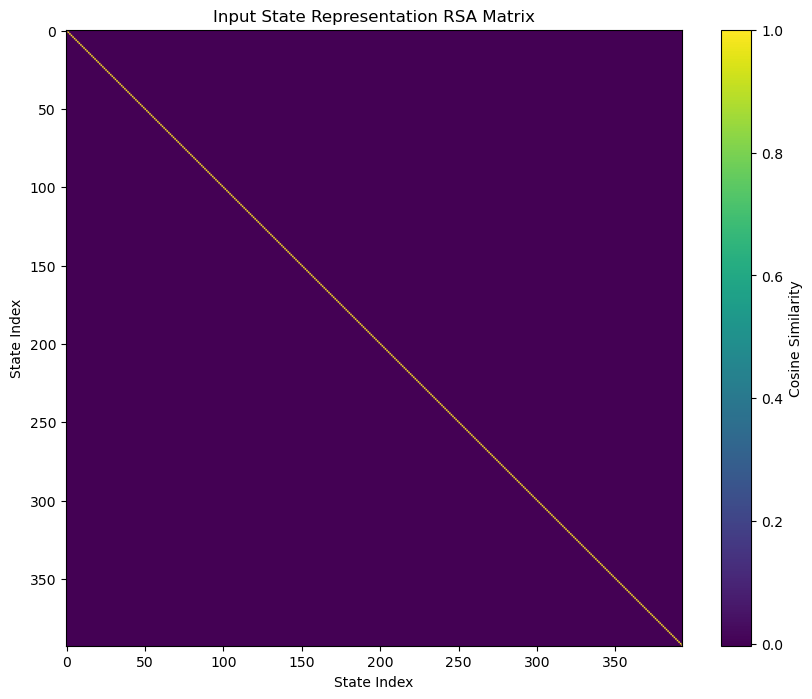

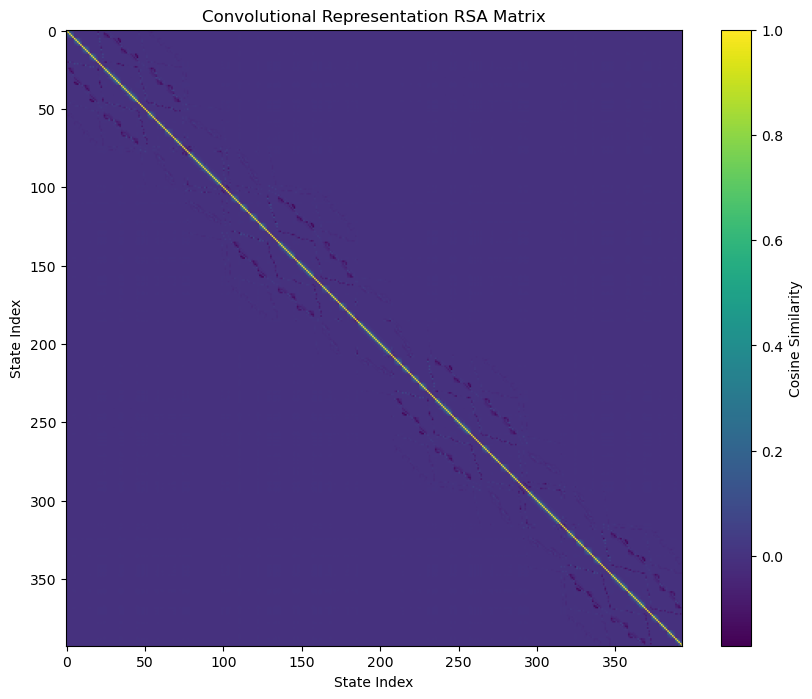

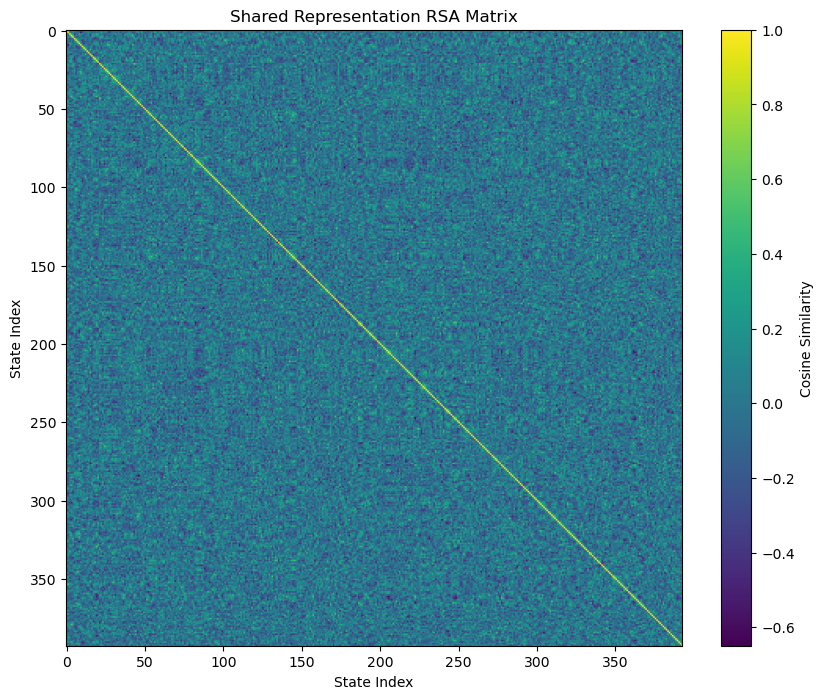

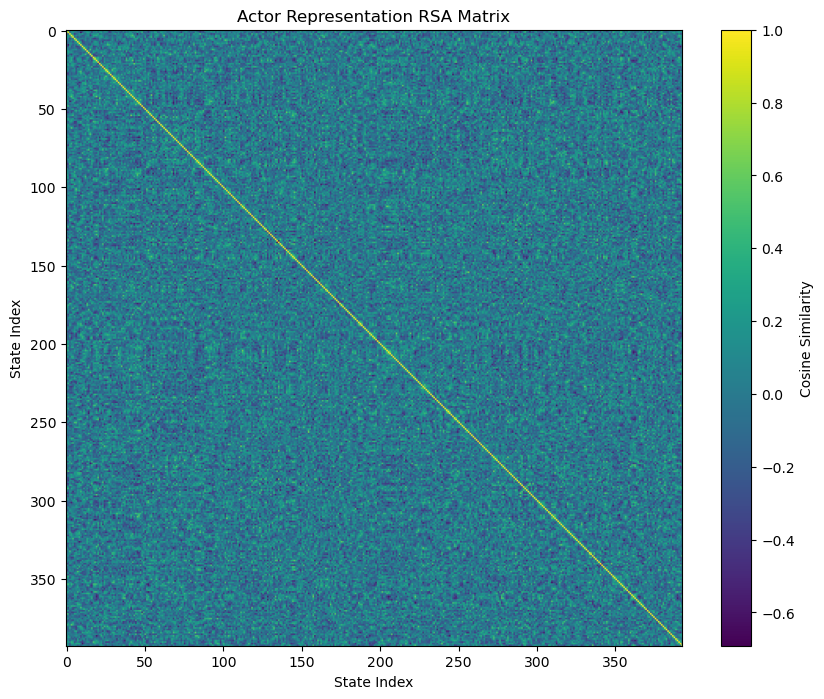

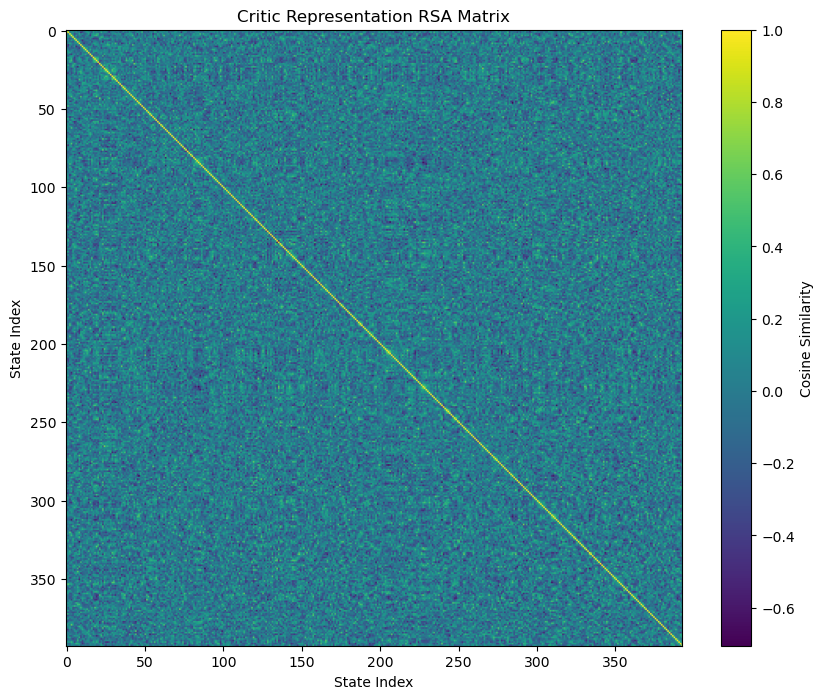

In [65]:
accumulate_and_plot(random_init_model, env)

In [66]:
model_dict = torch.load(f"{results_path}/ppo_model_500000.pth")

/tmp/ipykernel_1096816/1076323945.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(f"{results_path}/ppo_model_500000.pth")


In [67]:
# Check for any warnings
print("\nTrying to load...")
missing, unexpected = ppo_model._net.load_state_dict(model_dict["model_state_dict"], strict=False)
print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")


Trying to load...
Missing keys: []
Unexpected keys: []


In [68]:
model_dict = torch.load(f"{results_path}/ppo_model_500000.pth")
ppo_model._net.load_state_dict(model_dict["model_state_dict"], strict=True)
ppo_model._net.eval()

/tmp/ipykernel_1096816/2139354673.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(f"{results_path}/ppo_model_500000.pth")


ConvActorCritic(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (pi_fc): Linear(in_features=128, out_features=128, bias=True)
  (pi): Linear(in_features=128, out_features=4, bias=True)
  (v_fc): Linear(in_features=128, out_features=128, bias=True)
  (v): Linear(in_features=128, out_features=1, bias=True)
)

Input State Representation Shape: (393, 2025)
Convolutional Representation Shape: (393, 64800)
Shared Representation Shape: (393, 128)
Actor Representation Shape: (393, 128)
Critic Representation Shape: (393, 128)


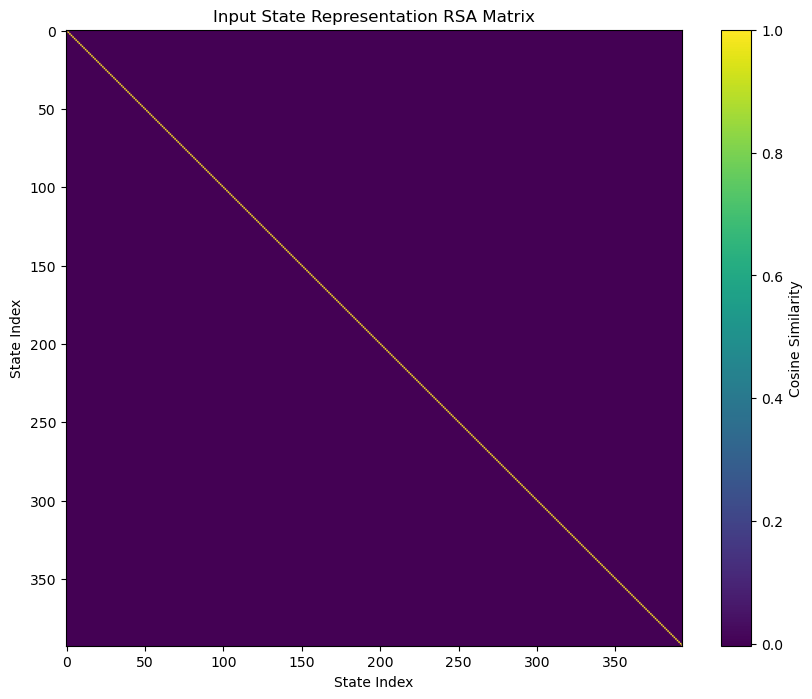

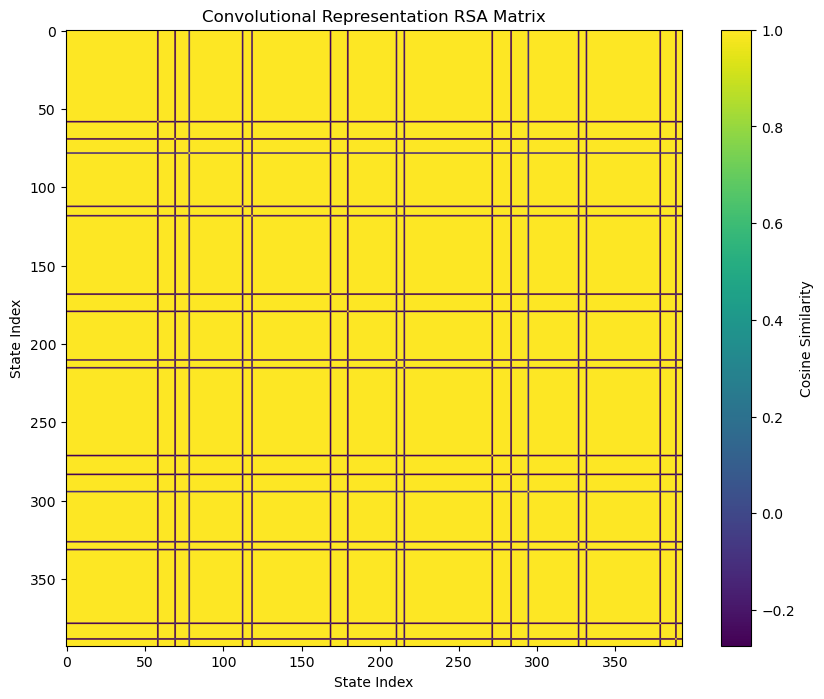

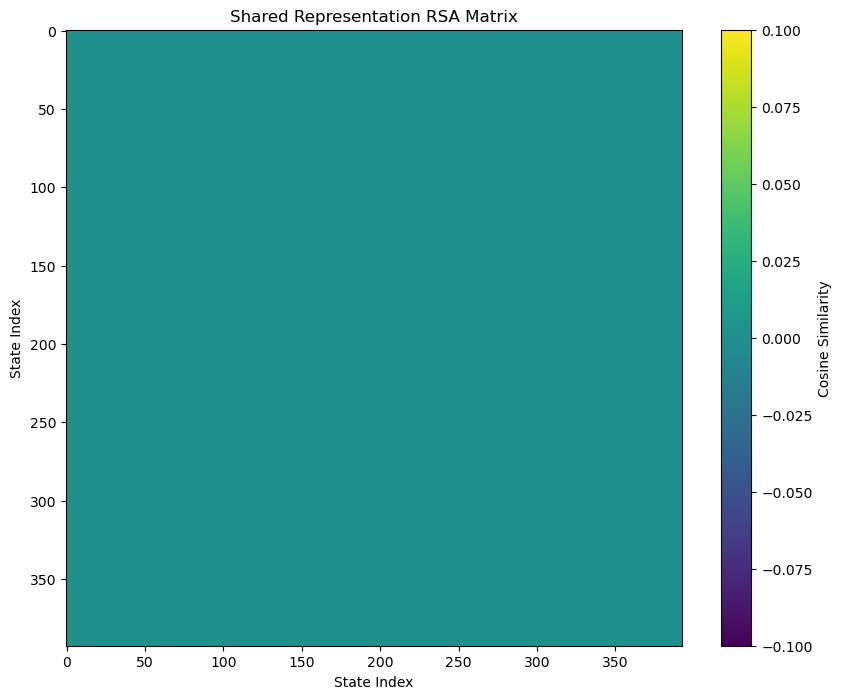

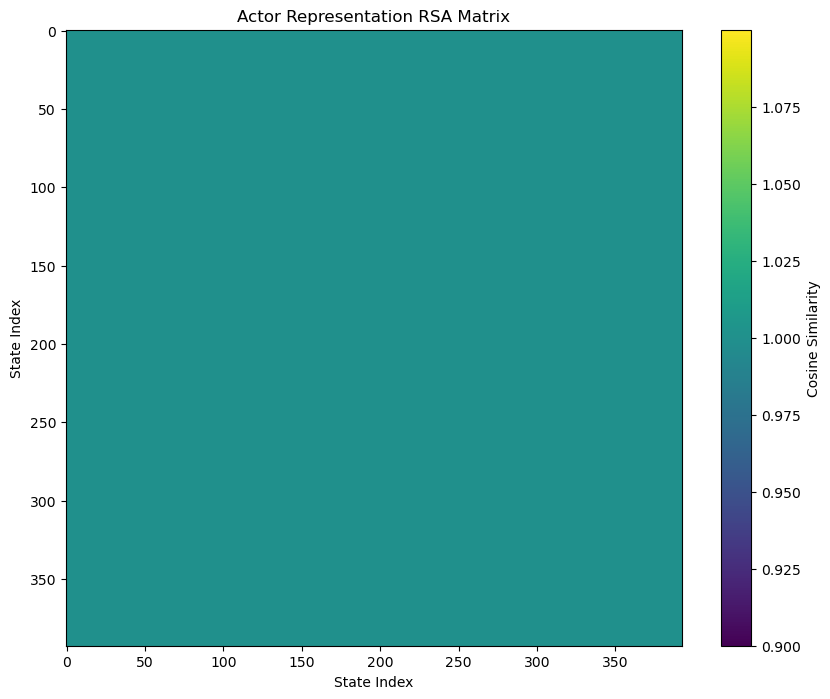

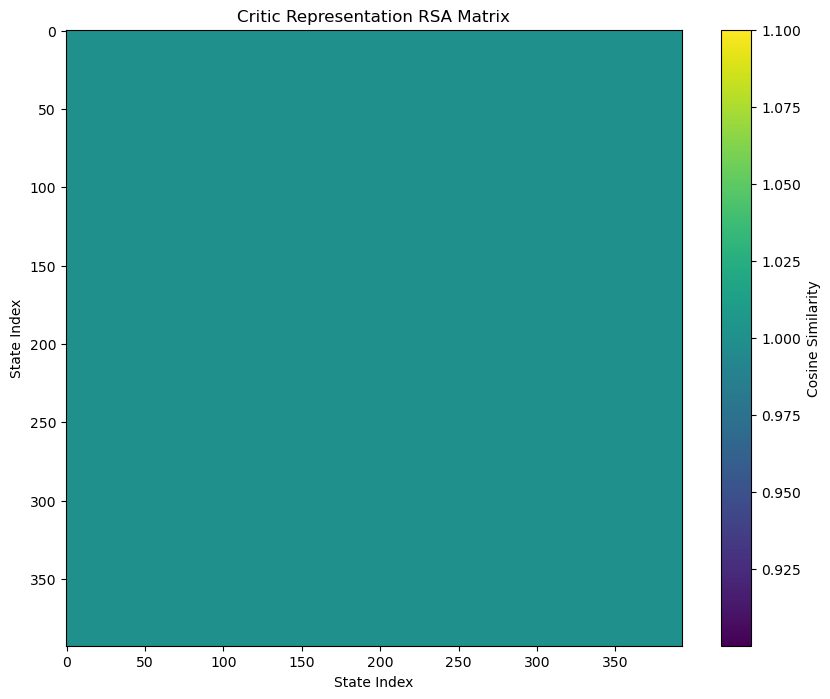

In [69]:
accumulate_and_plot(ppo_model, env)